In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dataset_train = pd.read_excel('demand_jan_maio.xlsx')
dataset_train.head()

,Consumption,next 8 hour
0,56443,43926.143750
1,51642,43902.985417
2,51757,43891.245833
3,51521,43879.418750
4,51295,43867.204167


In [3]:
training_set = []
Consumption = dataset_train['Consumption']
for i in range(int(len(dataset_train)/15)):
    training_set.append(sum(Consumption[i*15:(i*15)+15]))
217440/15

14496.0

In [4]:
# training_set = dataset_train.iloc[:, 0:1].values


In [5]:
dataset_train.shape

(217440, 2)

In [6]:
dataset_train.head()


,Consumption,next 8 hour
0,56443,43926.143750
1,51642,43902.985417
2,51757,43891.245833
3,51521,43879.418750
4,51295,43867.204167


In [7]:
training_set = np.array(training_set)
training_set.shape

(14496,)

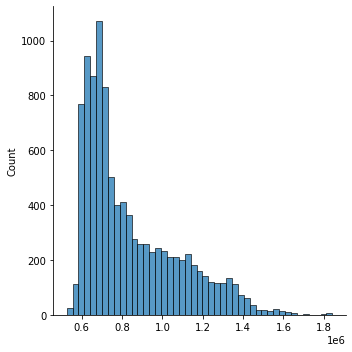

In [8]:
sns.displot(training_set[:10000])

/home/aminuninnova/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

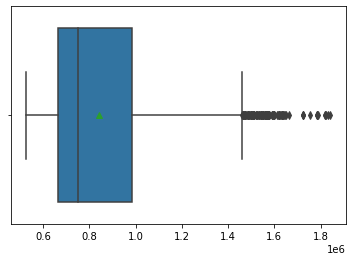

In [9]:
sns.boxplot(training_set[:10000], showmeans=True)

In [10]:
pd.DataFrame(training_set[:10000]).quantile(1)

0    1842000.0
Name: 1.0, dtype: float64

In [11]:
print(max(training_set[:10000]))

1842000


In [12]:
mu = np.mean(training_set[:10000])
std = np.std(training_set[:10000])
print(mu , std)
training_set_scaled = (training_set[:10000] - mu) / std
training_set_scaled

841602.8123 232073.30087586006


array([-0.30135656, -0.39616282, -0.43789963, ..., -0.98055576,
       -0.93773308, -0.87093092])

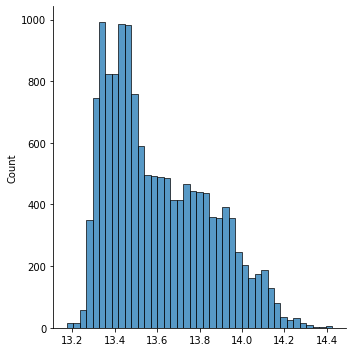

In [13]:
sns.displot(np.log(training_set))

In [14]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set[:10000].reshape(-1,1))
training_set_scaled

array([[0.18681347],
       [0.17009745],
       [0.1627385 ],
       ...,
       [0.0670586 ],
       [0.07460899],
       [0.0863874 ]])

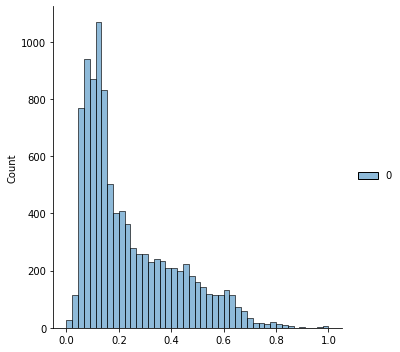

In [15]:
sns.displot(training_set_scaled)

In [16]:
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set_scaled = sc.fit_transform(training_set[:10000].reshape(-1,1))
# training_set_scaled

In [17]:
training_set_scaled.shape

(10000, 1)

In [18]:
print(480/15)
3 * 480 / 15

32.0


96.0

In [19]:
minutesAgoUpperBound = 96
minutesAgoLowerBound = 128

featureSize = minutesAgoLowerBound - minutesAgoUpperBound

minutespredict = 1
X_train = []
y_train = []
for i in range(minutesAgoLowerBound, 10000 - minutespredict):
    X_train.append(training_set_scaled[i - minutesAgoLowerBound:i-minutesAgoUpperBound, 0])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(9871, 32, 1)

In [20]:
y_train.shape

(9871, 1)

In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

2022-09-16 16:42:58.279312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 16:42:58.279345: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [22]:
model = Sequential()
model.add(LSTM(units=30,return_sequences=True,input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
model.add(LSTM(units=30,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=30,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dropout(0.2))
# model.add(Dense(units=minutespredict))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

2022-09-16 16:42:59.881891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-16 16:42:59.881908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 16:42:59.881921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a-ZenBook): /proc/driver/nvidia/version does not exist
2022-09-16 16:42:59.882393: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 32, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 32, 30)            7320      
                                                                 
 dropout (Dropout)           (None, 32, 30)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [23]:
# model.load('4layerLSTM_2DropOut.h5')
model.fit(X_train,y_train,epochs=100, batch_size=1000)

Epoch 1/100
10/10 [==============================] - 4s 119ms/step - loss: 0.0529
Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0311
Epoch 3/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0288
Epoch 4/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0279
Epoch 5/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0268
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0251
Epoch 7/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0235
Epoch 8/100
10/10 [==============================] - 1s 116ms/step - loss: 0.0229
Epoch 9/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0225
Epoch 10/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0222
Epoch 11/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0221
Epoch 12/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0217
Epoch 13/100


10/10 [==============================] - 1s 106ms/step - loss: 0.0165
Epoch 100/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0167


In [39]:
model.save('4layerLSTM_2DropOut.h5')

In [24]:
# url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/tatatest.csv'
# dataset_test = pd.read_csv(url)
# real_stock_price = dataset_test.iloc[:, 1:2].values
real_Consumption = training_set[10000:]
# real_Consumption = sc.transform(real_Consumption.reshape(-1,1))
real_Consumption

array([609481, 629571, 629000, ..., 876344, 835274, 824022])

In [25]:
# minutespredict = 480
# minutesAgo = 100

In [26]:
# training_set[10000 - minutesAgoLowerBound:].shape

In [27]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_train[len(dataset_total) - len(dataset_test) - 60:].values
inputs = training_set[10000 - minutesAgoLowerBound:]
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(minutesAgoLowerBound, len(inputs)):
    X_test.append(inputs[i-minutesAgoLowerBound:i-minutesAgoUpperBound, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test

array([[[0.11168177],
        [0.1034947 ],
        [0.10956434],
        ...,
        [0.06492902],
        [0.05190462],
        [0.06694691]],

       [[0.1034947 ],
        [0.10956434],
        [0.09997174],
        ...,
        [0.05190462],
        [0.06694691],
        [0.05566158]],

       [[0.10956434],
        [0.09997174],
        [0.10514944],
        ...,
        [0.06694691],
        [0.05566158],
        [0.06112571]],

       ...,

       [[0.53439465],
        [0.54041947],
        [0.5118164 ],
        ...,
        [0.2907663 ],
        [0.2941639 ],
        [0.3039548 ]],

       [[0.54041947],
        [0.5118164 ],
        [0.46899763],
        ...,
        [0.2941639 ],
        [0.3039548 ],
        [0.28985916]],

       [[0.5118164 ],
        [0.46899763],
        [0.47263304],
        ...,
        [0.3039548 ],
        [0.28985916],
        [0.30234793]]])

In [28]:
predicted_Consumption = model.predict(X_test)
# predicted_Consumption = sc.inverse_transform(predicted_Consumption)
predicted_Consumption.min()

0.0727355

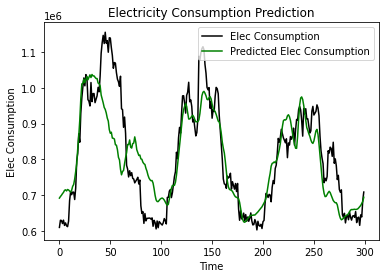

In [36]:

plt.plot(real_Consumption[:300], color = 'black', label = 'Elec Consumption')
plt.plot(sc.inverse_transform(predicted_Consumption[:300]), color = 'green', label = 'Predicted Elec Consumption')
plt.title('Electricity Consumption Prediction')
plt.xlabel('Time')
plt.ylabel('Elec Consumption')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(real_Consumption, sc.inverse_transform(predicted_Consumption))
print('mse: ', MSE)
print('RMSE: ', math.sqrt(MSE))

mse:  19290696555.988472
RMSE:  138890.95203067936
